In [1]:
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt
import lightkurve as lk
import astropy.units as u
import astropy.constants as c
from astropy.timeseries import LombScargle
from astropy.modeling import models, fitting
import pandas as pd


%matplotlib inline

In [2]:
# Define row headings
row_headings = ["Orbital Frequency (days⁻¹)", "Orbital Period (hours)", "Spin Frequency (days⁻¹)", "Spin Period (seconds)", "Model Spin Period (seconds)", "Model Spin Period Error (seconds)", "Model Spin Period Reduced χ2"]

# Create an empty DataFrame with NaNs
data = pd.DataFrame(np.nan, index=row_headings, columns=range(0, 5))

data.columns = ['0: Sector42', '1: Sector42', '2: Sector70', '3: Sector42', '4: Sector70']

## AO Piscium 0 

In [3]:
lc0 = np.genfromtxt("ao_piscium0.csv", delimiter=",")
time0 = lc0[0]
flux0 = lc0[1]
flux_error0 = lc0[2]

(2450.0, 2451.0)

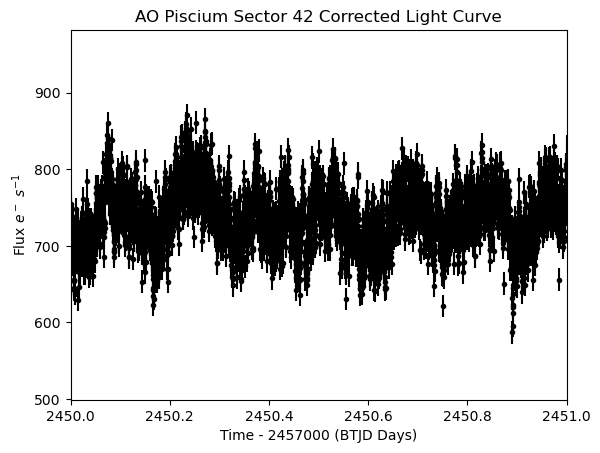

In [4]:
plt.errorbar(time0, flux0, yerr=flux_error0, fmt='k.')
plt.title('AO Piscium Sector 42 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(2450,2451)

Text(13, 0.02, '2$\\Omega$')

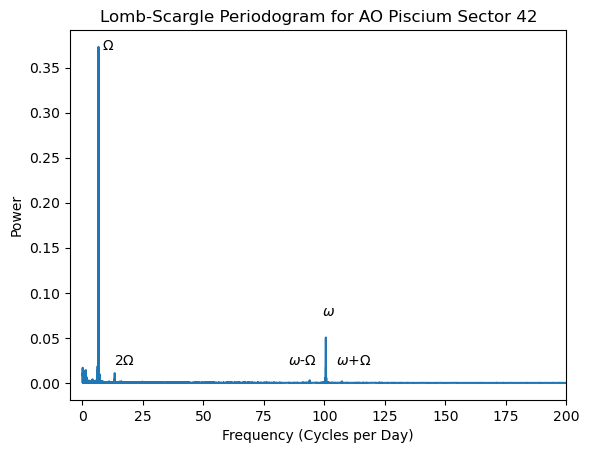

In [5]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency

frequencies01 = np.linspace(min_freq, max_freq, 1000000) 

power01 = LombScargle(time0, flux0).power(frequencies01)

plt.plot(frequencies01, power01)
plt.title('Lomb-Scargle Periodogram for AO Piscium Sector 42')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.37, '$\Omega$')
plt.text(99, 0.075, '$\omega$' )
plt.text(85, 0.02, '$\omega$-$\Omega$' )
plt.text(105, 0.02, '$\omega$+$\Omega$' )
plt.text(13, 0.02, '2$\Omega$')

In [6]:
forb0 = frequencies01[np.argmax(power01)]
print(forb0)

porb0 = 1/forb0
porb0h = porb0*u.day.to(u.hour)
print(porb0h)

min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency
frequencies02 = np.linspace(min_freq, max_freq, 1000000) 
power02 = LombScargle(time0, flux0).power(frequencies02)


fspin0 = frequencies02[np.argmax(power02)]
print(fspin0)

pspin0 = 1/fspin0
pspin0s = pspin0*u.day.to(u.s)
print(pspin0s)

6.683398092924564
3.5909876482455534
100.62891140210674
858.6001656596591


C:\Users\aisli\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\aisli\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(725.0, 775.0)

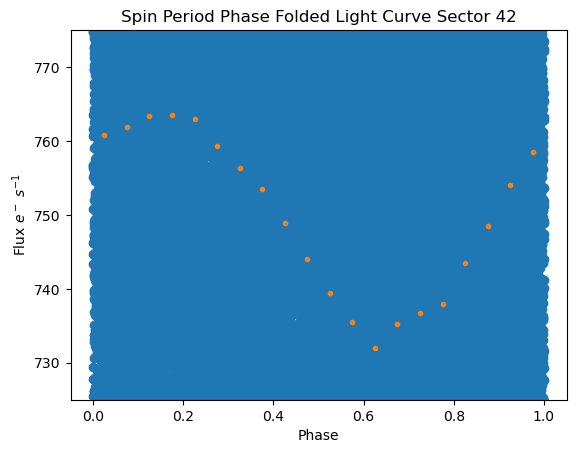

In [7]:
t0 = time0[0]

# Compute cycle number
n0 = (time0 - t0) / pspin0

# Compute new x-axis (integer cycles + phase)
spin_folded0 = (n0 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded0)
spin_folded_sorted0 = spin_folded0[sorted_indices]
spin_flux_sorted0 = flux0[sorted_indices]

dphase = 0.05
temp_phase= np.arange(0,1.001,dphase)

for i,phi_i in enumerate(temp_phase):
    phase_filt = np.where((spin_folded_sorted0>=phi_i) & (spin_folded_sorted0<(phi_i+dphase)))
    median_phase = np.median(spin_folded_sorted0[phase_filt])
    median_flux = np.median(spin_flux_sorted0[phase_filt])
    
    plt.plot(median_phase,median_flux,'C1.')

plt.scatter(spin_folded_sorted0, spin_flux_sorted0)
plt.title('Spin Period Phase Folded Light Curve Sector 42')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.ylim(725,775)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.223e+00  2.411e+00 ...  5.790e-01  5.208e-01]
           x: [ 4.107e+01  6.679e+00 -1.142e-01  3.099e+00  7.494e+02]
        cost: 192221.5527824515
         jac: [[ 5.460e-02 -1.807e+04 ...  2.390e-02  6.661e-02]
               [ 5.426e-02 -1.843e+04 ...  2.512e-02  6.665e-02]
               ...
               [ 5.331e-02 -1.085e+03 ... -2.951e-02  5.381e-02]
               [ 5.336e-02 -1.356e+03 ... -2.870e-02  5.393e-02]]
        grad: [-3.689e+01  4.240e+08  1.762e+05  2.857e+02 -6.431e+00]
  optimality: 423966380.7628541
 active_mask: [0 0 0 0 0]
        nfev: 48
        njev: None
   param_cov: [[ 8.142e-03  1.405e-09 ... -1.941e-05  4.232e-05]
               [ 1.405e-09  1.051e-11 ... -1.969e-10  4.426e-10]
               ...
               [-1.941e-05 -1.969e-10 ...  8.116e-03 -5.870e-06]
               [ 4.232e-05  4.426e-10 ... -5.870e-06  4.064e-03]]
6.62672985081020

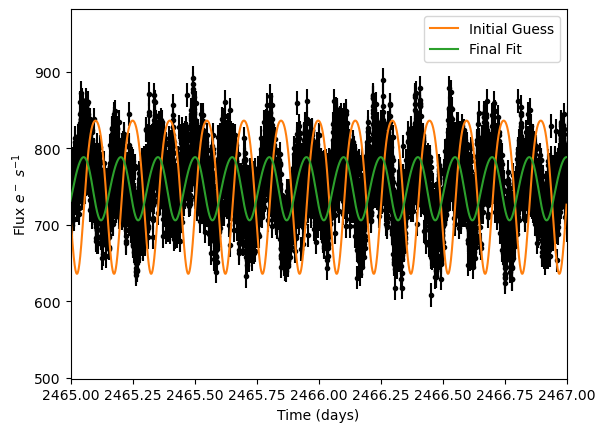

In [8]:
sine01 = models.Sine1D(amplitude=100, frequency=6.683398092924564, phase=0)
sine02 = models.Sine1D(amplitude=14, frequency=2*6.683398092924564, phase=0.25)
constant0 = models.Const1D(amplitude=750)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb0 = sine01 + sine02 + constant0

def tie_freq(model):
    return model.frequency_0 * 2

sine02.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine02.phase.tied = tie_phase

sin_final_orb0 = fit_sin(sin_init_orb0, time0, flux0, weights=1/flux_error0, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb0 = np.sum(((sin_final_orb0(time0)-flux0)/flux_error0)**2)
chi2_r_orb0 = chi2_orb0/(len(time0)-3)
print(chi2_r_orb0)

pfit_orb0 = fit_sin.fit_info.x
pcov_orb0 = fit_sin.fit_info.param_cov * chi2_r_orb0
print(pcov_orb0)
error_orb0 = []

for i in range(len(pfit_orb0)):
    error_orb0.append(np.absolute(pcov_orb0[i][i])**0.5)
        
perr_leastsq_orb0 = np.array(error_orb0) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb0)
print("perr = \ ", perr_leastsq_orb0)

plt.errorbar(time0, flux0 ,flux_error0 ,fmt='k.', zorder=1),
plt.plot(time0 ,sin_init_orb0(time0),'C1', label='Initial Guess', zorder=2)
plt.plot(time0 ,sin_final_orb0(time0),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(2465,2467)
plt.legend()
plt.show()

In [9]:
residual0 = flux0-sin_final_orb0(time0)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 42')

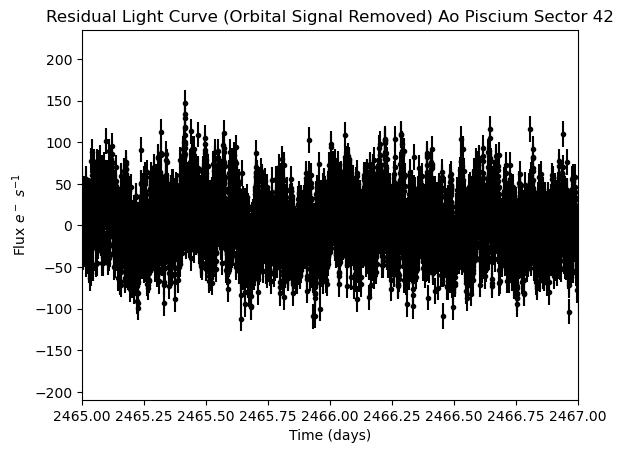

In [10]:
plt.errorbar(time0, residual0, yerr=flux_error0, fmt='k.')
plt.xlim(2465,2467)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 42')

(-5.0, 200.0)

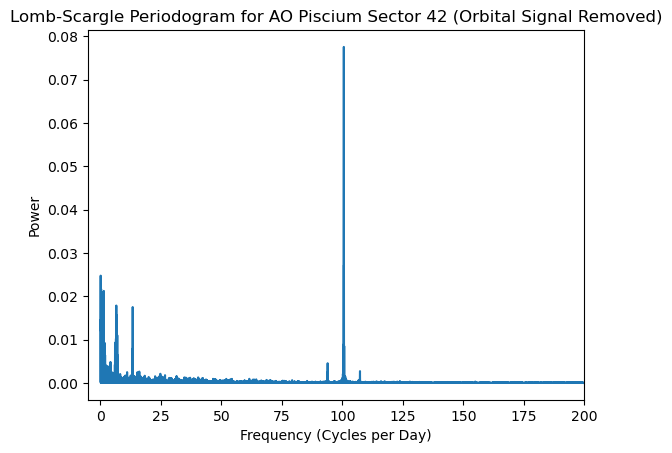

In [11]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency

frequencies03 = np.linspace(min_freq, max_freq, 1000000) 

power03 = LombScargle(time0, residual0).power(frequencies03)

plt.plot(frequencies03, power03)
plt.title('Lomb-Scargle Periodogram for AO Piscium Sector 42 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.931e+00  3.222e+00 ...  1.296e+00  1.294e+00]
           x: [ 1.550e+01  1.006e+02  2.314e+00]
        cost: 177455.77085908354
         jac: [[ 4.572e-02  1.155e+04  4.717e+00]
               [ 5.233e-02  9.839e+03  4.020e+00]
               ...
               [ 4.629e-02  6.601e+03  2.672e+00]
               [ 4.991e-02  4.918e+03  1.991e+00]]
        grad: [-3.051e-05 -1.659e+03 -6.714e-01]
  optimality: 1659.1441537570208
 active_mask: [0 0 0]
        nfev: 7
        njev: 6
   param_cov: [[ 8.130e-03  7.663e-09 -1.883e-05]
               [ 7.663e-09  1.430e-08 -3.519e-05]
               [-1.883e-05 -3.519e-05  8.659e-02]]
6.117687829113094
[[ 4.97380409e-02  4.68800742e-08 -1.15173486e-04]
 [ 4.68800742e-08  8.74980110e-08 -2.15290059e-04]
 [-1.15173486e-04 -2.15290059e-04  5.29729394e-01]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [ 15.49507783 

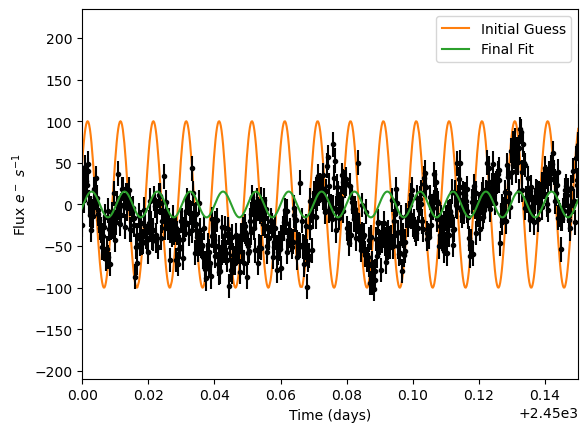

In [12]:
sine01 = models.Sine1D(amplitude=100, frequency=100.62891140210674, phase=0.25)
sine02 = models.Sine1D(amplitude=10, frequency=100.62891140210674-6.683398092924564, phase=0.5)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin0 = sine01 #+ sine02

def tie_freq(model):
    return model.frequency_0 - 6.683398092924564

sine02.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine02.phase.tied = tie_phase

sin_final_spin0 = fit_sin(sin_init_spin0, time0, residual0, weights=1/flux_error0, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin0 = np.sum(((sin_final_spin0(time0)-residual0)/flux_error0)**2)
chi2_r_spin0 = chi2_spin0/(len(time0)-3)
print(chi2_r_spin0)

pfit_spin0 = fit_sin.fit_info.x
pcov_spin0 = fit_sin.fit_info.param_cov * chi2_r_spin0
print(pcov_spin0)
error_spin0 = []

for i in range(len(pfit_spin0)):
    error_spin0.append(np.absolute(pcov_spin0[i][i])**0.5)
        
perr_leastsq_spin0 = np.array(error_spin0) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin0)
print("perr = \ ", perr_leastsq_spin0)

plt.errorbar(time0, residual0, flux_error0, fmt='k.', zorder=2),
plt.plot(time0, sin_init_spin0(time0),'C1', label='Initial Guess', zorder=1)
plt.plot(time0, sin_final_spin0(time0),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(2450, 2450.15)
plt.show()

In [13]:
pspin0_model = 1/pfit_spin0[1]
pspin0_models = pspin0_model*u.day.to(u.s)

pspin0_model_error = (1/pfit_spin0[1])*(perr_leastsq_spin0[1])
pspin0_model_errors = pspin0_model_error*u.day.to(u.s)

print(pspin0_models)
print(pspin0_model_errors)

858.6077738824306
0.25397671802946525


## AO Piscium 1

In [14]:
lc1 = np.genfromtxt("ao_piscium1.csv", delimiter=",")
time1 = lc1[0]
flux1 = lc1[1]
flux_error1 = lc1[2]

(2450.0, 2451.0)

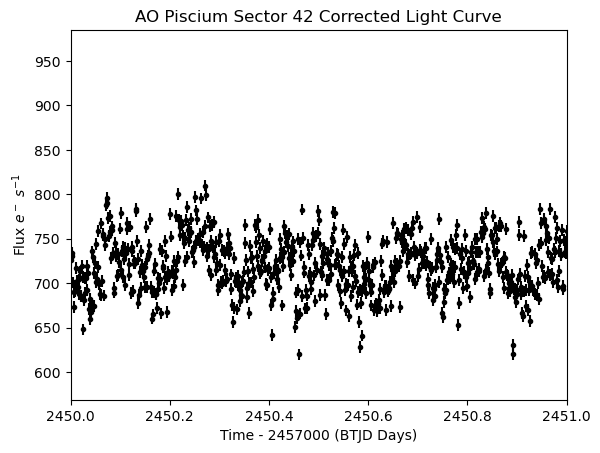

In [15]:
plt.errorbar(time1, flux1, yerr=flux_error1, fmt='k.')
plt.title('AO Piscium Sector 42 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(2450,2451)

Text(13, 0.02, '2$\\Omega$')

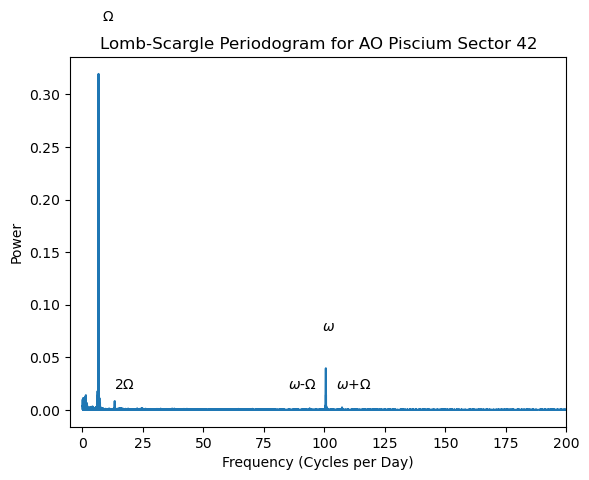

In [16]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time1)))  # Nyquist frequency

frequencies11 = np.linspace(min_freq, max_freq, 1000000) 

power11 = LombScargle(time1, flux1).power(frequencies11)

plt.plot(frequencies11, power11)
plt.title('Lomb-Scargle Periodogram for AO Piscium Sector 42')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.37, '$\Omega$')
plt.text(99, 0.075, '$\omega$' )
plt.text(85, 0.02, '$\omega$-$\Omega$' )
plt.text(105, 0.02, '$\omega$+$\Omega$' )
plt.text(13, 0.02, '2$\Omega$')

In [17]:
forb1 = frequencies11[np.argmax(power11)]
print(forb1)

porb1 = 1/forb1
porb1h = porb1*u.day.to(u.hour)
print(porb1h)

min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time1)))  # Nyquist frequency
frequencies12 = np.linspace(min_freq, max_freq, 1000000) 
power12 = LombScargle(time1, flux1).power(frequencies12)


fspin1 = frequencies12[np.argmax(power12)]
print(fspin1)

pspin1 = 1/fspin1
pspin1s = pspin1*u.day.to(u.s)
print(pspin1s)

6.682598313429241
3.591417420940892
100.6281825515565
858.6063845059833


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

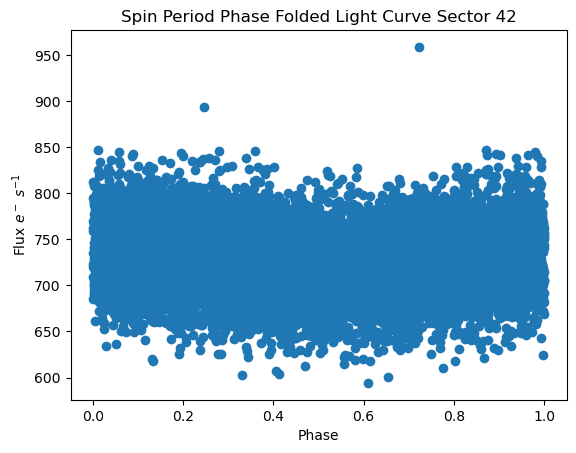

In [18]:
t1 = time1[0]

# Compute cycle number
n1 = (time1 - t1) / pspin1

# Compute new x-axis (integer cycles + phase)
spin_folded1 = (n1 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded1)
spin_folded_sorted1 = spin_folded1[sorted_indices]
spin_flux_sorted1 = flux1[sorted_indices]

plt.scatter(spin_folded_sorted1, spin_flux_sorted1)
plt.title('Spin Period Phase Folded Light Curve Sector 42')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 6.589e+00  1.100e+00 ...  3.868e+00 -1.682e+00]
           x: [ 2.967e+01  6.683e+00  9.131e-02  4.704e+00  7.280e+02]
        cost: 99949.09712805338
         jac: [[ 1.483e-01 -1.292e+04 ... -1.408e-01  1.494e-01]
               [ 1.469e-01 -1.474e+04 ... -1.455e-01  1.492e-01]
               ...
               [ 1.174e-01 -1.255e+04 ... -1.180e-01  1.198e-01]
               [ 1.153e-01 -1.389e+04 ... -1.191e-01  1.193e-01]]
        grad: [-5.949e+01  5.791e+06  3.834e+03 -5.024e+00  5.001e-01]
  optimality: 5790992.275887451
 active_mask: [0 0 0 0 0]
        nfev: 71
        njev: None
   param_cov: [[ 9.539e-03 -4.271e-10 ... -3.282e-05  4.403e-05]
               [-4.271e-10  5.468e-12 ... -1.103e-10 -9.229e-11]
               ...
               [-3.282e-05 -1.103e-10 ...  9.542e-03 -1.231e-06]
               [ 4.403e-05 -9.229e-11 ... -1.231e-06  4.768e-03]]
20.2039816308981

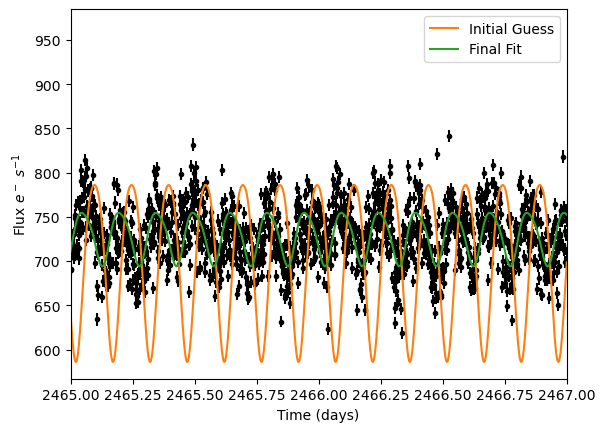

In [19]:
sine11 = models.Sine1D(amplitude=100, frequency=6.682598313429241, phase=0)
sine12 = models.Sine1D(amplitude=14, frequency=2*6.682598313429241, phase=0.25)
constant1 = models.Const1D(amplitude=700)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb1 = sine11 + sine12 + constant1

def tie_freq(model):
    return model.frequency_0 * 2

sine12.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine12.phase.tied = tie_phase

sin_final_orb1 = fit_sin(sin_init_orb1, time1, flux1, weights=1/flux_error1, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb1 = np.sum(((sin_final_orb1(time1)-flux1)/flux_error1)**2)
chi2_r_orb1 = chi2_orb1/(len(time1)-3)
print(chi2_r_orb1)

pfit_orb1 = fit_sin.fit_info.x
pcov_orb1 = fit_sin.fit_info.param_cov * chi2_r_orb1
print(pcov_orb1)
error_orb1 = []

for i in range(len(pfit_orb1)):
    error_orb1.append(np.absolute(pcov_orb1[i][i])**0.5)
        
perr_leastsq_orb1 = np.array(error_orb1) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb1)
print("perr = \ ", perr_leastsq_orb1)

plt.errorbar(time1, flux1, flux_error1, fmt='k.', zorder=1),
plt.plot(time1 ,sin_init_orb1(time1),'C1', label='Initial Guess', zorder=2)
plt.plot(time1 ,sin_final_orb1(time1),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(2465,2467)
plt.legend()
plt.show()

In [20]:
residual1 = flux1-sin_final_orb1(time1)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 42')

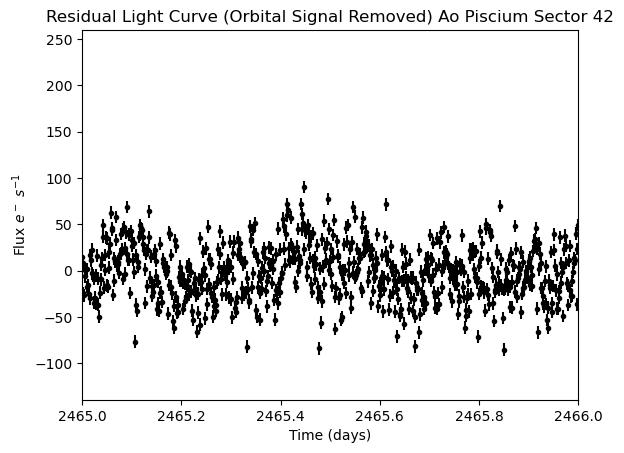

In [21]:
plt.errorbar(time1, residual1, yerr=flux_error1, fmt='k.')
plt.xlim(2465,2466)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 42')

(-5.0, 200.0)

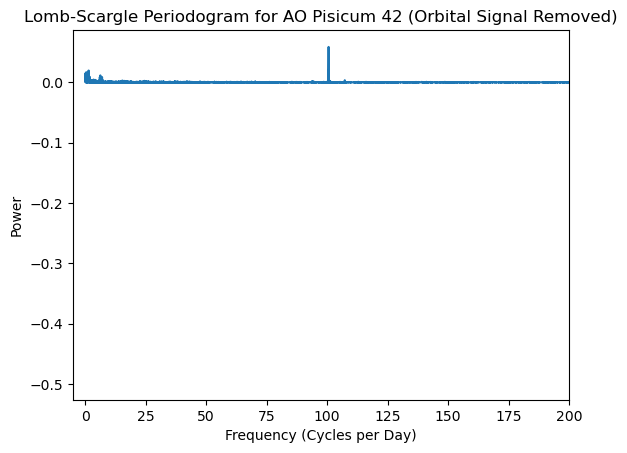

In [22]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency

frequencies13 = np.linspace(min_freq, max_freq, 1000000) 

power13 = LombScargle(time1, residual1).power(frequencies13)

plt.plot(frequencies13, power13)
plt.title('Lomb-Scargle Periodogram for AO Pisicum 42 (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 7.757e+00  2.527e+00 ...  4.055e+00 -6.817e-01]
           x: [-9.344e+00  1.006e+02 -9.694e-02  2.059e+00]
        cost: 94061.7904483894
         jac: [[-1.343e-01  7.942e+01  5.696e+00 -4.217e-02]
               [-1.359e-01 -2.714e+01 -1.946e+00  7.589e-02]
               ...
               [-4.295e-02 -6.453e+01  7.337e+00 -1.039e-01]
               [-1.130e-01 -3.295e+01  3.746e+00 -2.725e-02]]
        grad: [ 1.217e+02  7.105e+03 -4.565e+03  2.373e+01]
  optimality: 7105.352532178061
 active_mask: [0 0 0 0]
        nfev: 35
        njev: None
   param_cov: [[ 9.534e-03  1.044e-08 -1.481e-07 -1.039e-05]
               [ 1.044e-08  4.406e-08 -5.031e-08  3.804e-08]
               [-1.481e-07 -5.031e-08  2.698e-06 -7.433e-07]
               [-1.039e-05  3.804e-08 -7.433e-07  9.536e-03]]
19.013905487849083
[[ 1.81270189e-01  1.98418536e-07 -2.81517367e-06 -1.97513466e-04]
 [ 1.9

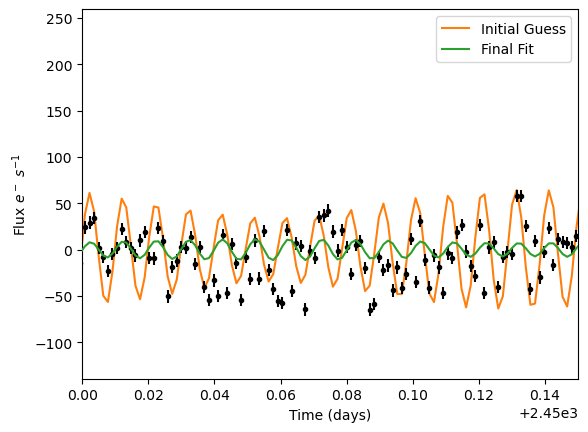

In [23]:
sine11 = models.Sine1D(amplitude=50, frequency=100.6281825515565, phase=0)
sine12 = models.Sine1D(amplitude=15, frequency=100.6281825515565-6.682598313429241, phase=0.25)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin1 = sine11 + sine12

def tie_freq(model):
    return model.frequency_0 - 6.682598313429241

sine12.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine12.phase.tied = tie_phase

sin_final_spin1 = fit_sin(sin_init_spin1, time1, residual1, weights=1/flux_error1, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin1 = np.sum(((sin_final_spin1(time1)-residual1)/flux_error1)**2)
chi2_r_spin1 = chi2_spin1/(len(time1)-3)
print(chi2_r_spin1)

pfit_spin1 = fit_sin.fit_info.x
pcov_spin1 = fit_sin.fit_info.param_cov * chi2_r_spin1
print(pcov_spin1)
error_spin1 = []

for i in range(len(pfit_spin1)):
    error_spin1.append(np.absolute(pcov_spin1[i][i])**0.5)
        
perr_leastsq_spin1 = np.array(error_spin1) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin1)
print("perr = \ ", perr_leastsq_spin1)

plt.errorbar(time1, residual1, flux_error1, fmt='k.', zorder=2),
plt.plot(time1, sin_init_spin1(time1),'C1', label='Initial Guess', zorder=1)
plt.plot(time1, sin_final_spin1(time1),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(2450, 2450.15)
plt.show()

In [24]:
pspin1_model = 1/pfit_spin1[1]
pspin1_models = pspin1_model*u.day.to(u.s)

pspin1_model_error = (1/pfit_spin1[1])*(perr_leastsq_spin1[1])
pspin1_model_errors = pspin1_model_error*u.day.to(u.s)

print(pspin1_models)
print(pspin1_model_errors)

858.6080871767409
0.7858945625475348


## AO Piscium 2

In [25]:
lc2 = np.genfromtxt("ao_piscium2.csv", delimiter=",")
time2 = lc2[0]
flux2 = lc2[1]
flux_error2 = lc2[2]

(3210.0, 3211.0)

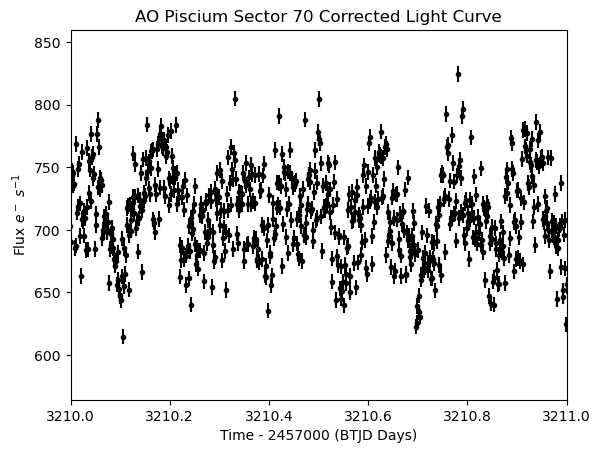

In [26]:
plt.errorbar(time2, flux2, yerr=flux_error2, fmt='k.')
plt.title('AO Piscium Sector 70 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3210,3211)

Text(13, 0.02, '2$\\Omega$')

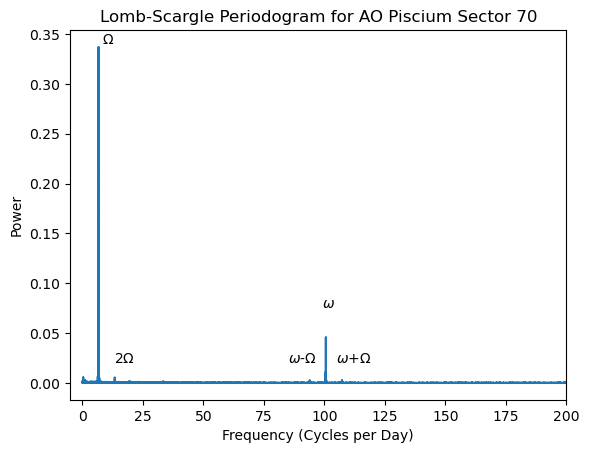

In [27]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency

frequencies21 = np.linspace(min_freq, max_freq, 1000000) 

power21 = LombScargle(time2, flux2).power(frequencies21)

plt.plot(frequencies21, power21)
plt.title('Lomb-Scargle Periodogram for AO Piscium Sector 70')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.34, '$\Omega$')
plt.text(99, 0.075, '$\omega$' )
plt.text(85, 0.02, '$\omega$-$\Omega$' )
plt.text(105, 0.02, '$\omega$+$\Omega$' )
plt.text(13, 0.02, '2$\Omega$')

In [28]:
forb2 = frequencies21[np.argmax(power21)]
print(forb2)

porb2 = 1/forb2
porb2h = porb2*u.day.to(u.hour)
print(porb2h)

min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency
frequencies22 = np.linspace(min_freq, max_freq, 1000000) 
power22 = LombScargle(time2, flux2).power(frequencies22)


fspin2 = frequencies22[np.argmax(power22)]
print(fspin2)

pspin2 = 1/fspin2
pspin2s = pspin2*u.day.to(u.s)
print(pspin2s)

6.683967240225722
3.590681871622923
100.62789417990281
858.6088450339014


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

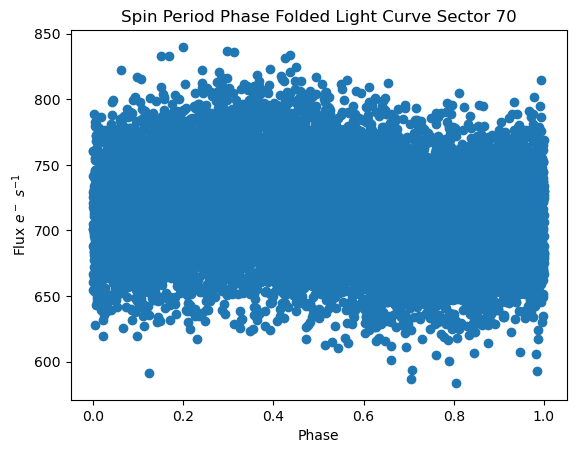

In [29]:
t2 = time2[0]

# Compute cycle number
n2 = (time2 - t2) / pspin2

# Compute new x-axis (integer cycles + phase)
spin_folded2 = (n2 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded2)
spin_folded_sorted2 = spin_folded2[sorted_indices]
spin_flux_sorted2 = flux2[sorted_indices]

plt.scatter(spin_folded_sorted2, spin_flux_sorted2)
plt.title('Spin Period Phase Folded Light Curve Sector 70')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-6.722e-02 -3.138e-01 ...  2.592e+00  5.968e+00]
           x: [ 7.147e+00  6.682e+00  2.410e-01 -9.263e-01  7.150e+02]
        cost: 185974.40505463397
         jac: [[ 1.382e-01  1.171e+04 ...  1.259e-01  1.569e-01]
               [ 1.427e-01  1.101e+04 ...  1.145e-01  1.574e-01]
               ...
               [-5.016e-02  1.358e+04 ... -8.736e-02  1.324e-01]
               [-4.294e-02  1.371e+04 ... -7.520e-02  1.324e-01]]
        grad: [-3.715e+03 -1.059e+08 -3.824e+04  1.864e+01  2.634e+01]
  optimality: 105919742.85209548
 active_mask: [0 0 0 0 0]
        nfev: 39
        njev: None
   param_cov: [[ 5.701e-03  1.544e-09 ...  3.111e-05  1.354e-05]
               [ 1.544e-09  1.550e-10 ... -5.554e-10 -1.685e-09]
               ...
               [ 3.111e-05 -5.554e-10 ...  5.706e-03  2.603e-06]
               [ 1.354e-05 -1.685e-09 ...  2.603e-06  2.854e-03]]
27.52729500512

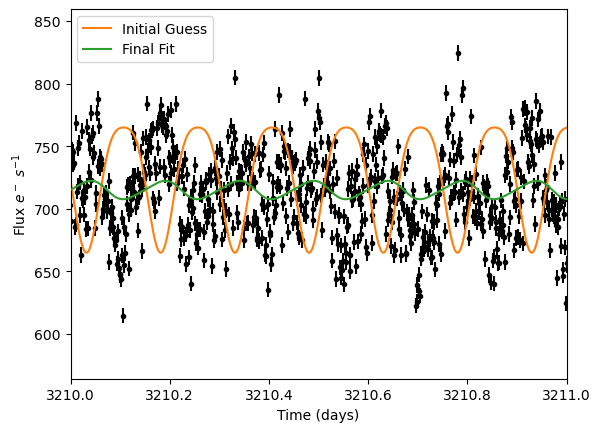

In [30]:
sine21 = models.Sine1D(amplitude=50, frequency=6.683967240225722, phase=0)
sine22 = models.Sine1D(amplitude=10, frequency=2*6.683967240225722, phase=0.25)
constant2 = models.Const1D(amplitude=725)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb2 = sine21 + sine22 + constant2

def tie_freq(model):
    return model.frequency_0 * 2

sine22.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine22.phase.tied = tie_phase

sin_final_orb2 = fit_sin(sin_init_orb2, time2, flux2, weights=1/flux_error2, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb2 = np.sum(((sin_final_orb2(time2)-flux2)/flux_error2)**2)
chi2_r_orb2 = chi2_orb2/(len(time2)-3)
print(chi2_r_orb2)

pfit_orb2 = fit_sin.fit_info.x
pcov_orb2 = fit_sin.fit_info.param_cov * chi2_r_orb2
print(pcov_orb2)
error_orb2 = []

for i in range(len(pfit_orb2)):
    error_orb2.append(np.absolute(pcov_orb2[i][i])**0.5)
        
perr_leastsq_orb2 = np.array(error_orb2) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb2)
print("perr = \ ", perr_leastsq_orb2)

plt.errorbar(time2, flux2, flux_error2, fmt='k.', zorder=1),
plt.plot(time2, sin_init_orb2(time2),'C1', label='Initial Guess', zorder=2)
plt.plot(time2, sin_final_orb2(time2),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3210,3211)
plt.legend()
plt.show()

In [31]:
residual2 = flux2-sin_final_orb2(time2)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 70')

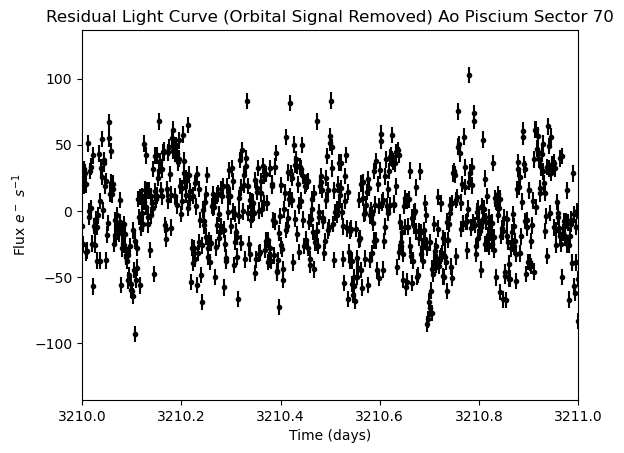

In [32]:
plt.errorbar(time2, residual2, yerr=flux_error2, fmt='k.')
plt.xlim(3210,3211)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 70')

(-5.0, 200.0)

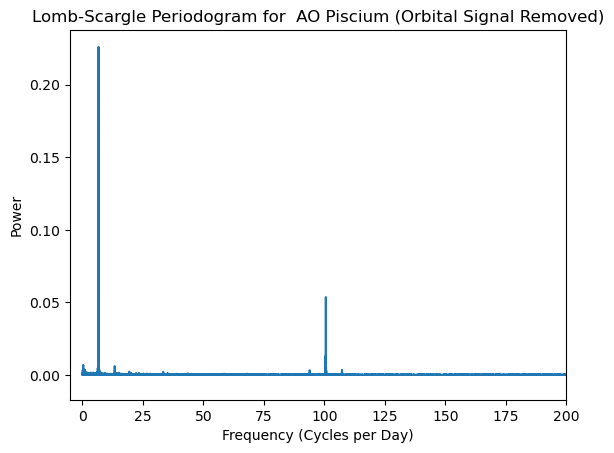

In [33]:
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time0)))  # Nyquist frequency

frequencies23 = np.linspace(min_freq, max_freq, 1000000) 

power23 = LombScargle(time2, residual2).power(frequencies23)

plt.plot(frequencies23, power23)
plt.title('Lomb-Scargle Periodogram for  AO Piscium (Orbital Signal Removed)')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-1.133e-01 -1.655e-01 ...  2.390e+00  5.640e+00]
           x: [-2.351e+00  1.006e+02 -7.607e-02 -9.622e-01]
        cost: 182541.22175401018
         jac: [[-1.185e-03 -1.026e+02  1.420e+00  5.082e-02]
               [-1.219e-01 -7.822e+01  1.082e+00  1.437e-01]
               ...
               [ 1.139e-01  8.277e+01 -1.683e+00 -6.798e-02]
               [ 1.246e-01  5.450e+00 -1.108e-01  3.662e-02]]
        grad: [ 1.395e+03 -4.240e+04 -3.815e+01 -4.297e+02]
  optimality: 42395.500543357644
 active_mask: [0 0 0 0]
        nfev: 35
        njev: None
   param_cov: [[ 5.707e-03  2.043e-09 -3.462e-07 -2.125e-05]
               [ 2.043e-09  4.118e-07  2.488e-05  3.809e-09]
               [-3.462e-07  2.488e-05  1.525e-03  1.404e-06]
               [-2.125e-05  3.809e-09  1.404e-06  5.707e-03]]
27.01912696181323
[[ 1.54195424e-01  5.51869161e-08 -9.35481302e-06 -5.74142628e-04]
 [ 5

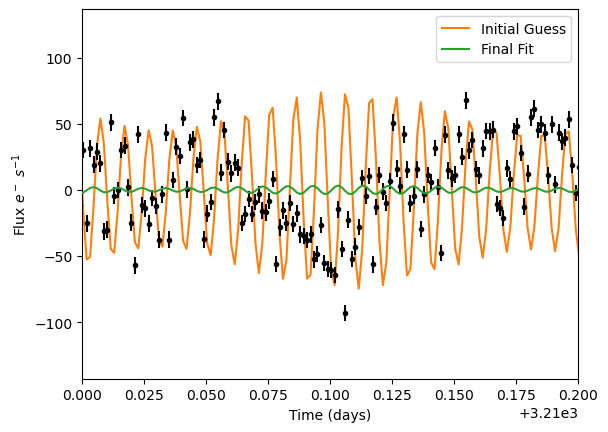

In [34]:
sine21 = models.Sine1D(amplitude=60, frequency=100.62789417990281, phase=0)
sine22 = models.Sine1D(amplitude=15, frequency=100.62789417990281-6.683967240225722, phase=0.25)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin2 = sine21 + sine22

def tie_freq(model):
    return model.frequency_0 -6.683967240225722

sine22.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine22.phase.tied = tie_phase

sin_final_spin2 = fit_sin(sin_init_spin2, time2, residual2, weights=1/flux_error2, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin2 = np.sum(((sin_final_spin2(time2)-residual2)/flux_error2)**2)
chi2_r_spin2 = chi2_spin2/(len(time2)-3)
print(chi2_r_spin2)

pfit_spin2 = fit_sin.fit_info.x
pcov_spin2 = fit_sin.fit_info.param_cov * chi2_r_spin2
print(pcov_spin2)
error_spin2 = []

for i in range(len(pfit_spin2)):
    error_spin2.append(np.absolute(pcov_spin2[i][i])**0.5)
        
perr_leastsq_spin2 = np.array(error_spin2) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin2)
print("perr = \ ", perr_leastsq_spin2)

plt.errorbar(time2, residual2, flux_error2, fmt='k.', zorder=2),
plt.plot(time2, sin_init_spin2(time2),'C1', label='Initial Guess', zorder=1)
plt.plot(time2, sin_final_spin2(time2),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3210, 3210.2)
plt.show()

In [35]:
pspin2_model = 1/pfit_spin2[1]
pspin2_models = pspin2_model*u.day.to(u.s)

pspin2_model_error = (1/pfit_spin2[1])*(perr_leastsq_spin2[1])
pspin2_model_errors = pspin2_model_error*u.day.to(u.s)

print(pspin2_models)
print(pspin2_model_errors)

858.6516529020655
2.863985431956261


## AO Piscium 3

In [36]:
lc3 = np.genfromtxt("ao_piscium3.csv", delimiter=",")
time3 = lc3[0]
flux3 = lc3[1]
flux_error3 = lc3[2]

(2450.0, 2451.0)

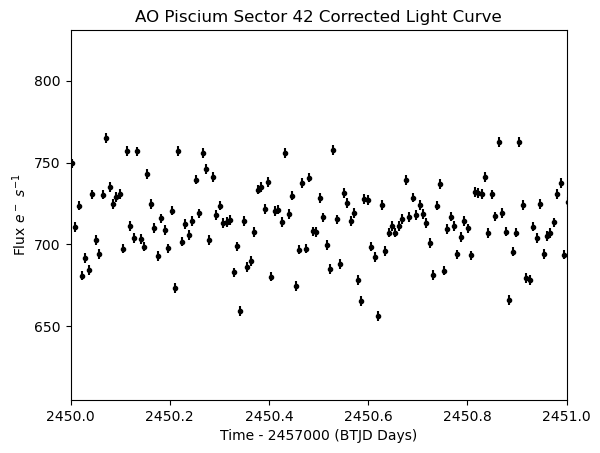

In [37]:
plt.errorbar(time3, flux3, yerr=flux_error3, fmt='k.')
plt.title('AO Piscium Sector 42 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(2450,2451)

Text(13, 0.02, '2$\\Omega$')

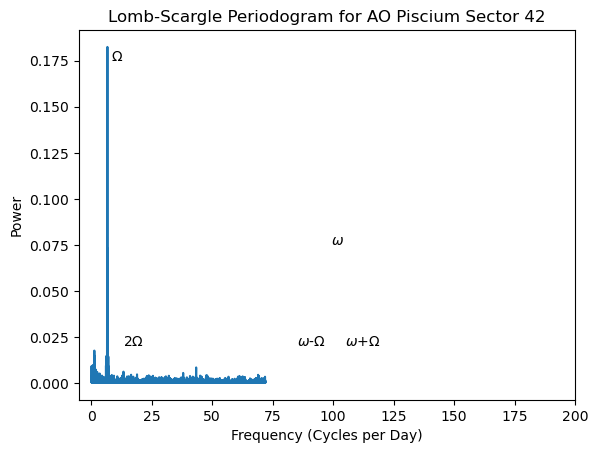

In [38]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time3)))  # Nyquist frequency

frequencies31 = np.linspace(min_freq, max_freq, 1000000) 

power31 = LombScargle(time3, flux3).power(frequencies31)

plt.plot(frequencies31, power31)
plt.title('Lomb-Scargle Periodogram for AO Piscium Sector 42')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.175, '$\Omega$')
plt.text(99, 0.075, '$\omega$' )
plt.text(85, 0.02, '$\omega$-$\Omega$' )
plt.text(105, 0.02, '$\omega$+$\Omega$' )
plt.text(13, 0.02, '2$\Omega$')

## AO Piscium 4

In [39]:
lc4 = np.genfromtxt("ao_piscium4.csv", delimiter=",")
time4 = lc4[0]
flux4 = lc4[1]
flux_error4 = lc4[2]

(3210.0, 3211.0)

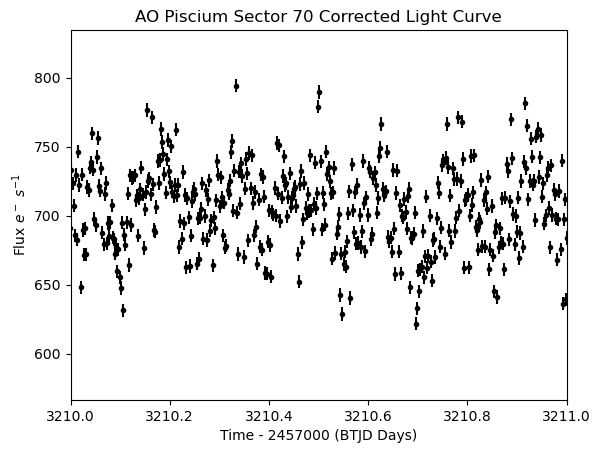

In [40]:
plt.errorbar(time4, flux4, yerr=flux_error4, fmt='k.')
plt.title('AO Piscium Sector 70 Corrected Light Curve')
plt.xlabel('Time - 2457000 (BTJD Days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3210, 3211)

Text(13, 0.02, '2$\\Omega$')

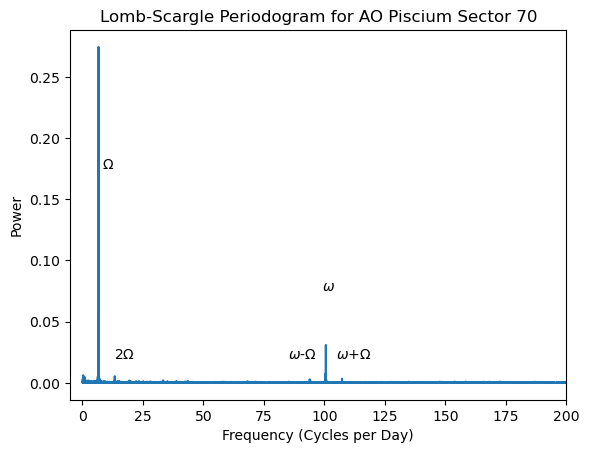

In [41]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time2)))  # Nyquist frequency

frequencies41 = np.linspace(min_freq, max_freq, 1000000) 

power41 = LombScargle(time4, flux4).power(frequencies41)

plt.plot(frequencies41, power41)
plt.title('Lomb-Scargle Periodogram for AO Piscium Sector 70')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(-5, 200)
plt.text(8, 0.175, '$\Omega$')
plt.text(99, 0.075, '$\omega$' )
plt.text(85, 0.02, '$\omega$-$\Omega$' )
plt.text(105, 0.02, '$\omega$+$\Omega$' )
plt.text(13, 0.02, '2$\Omega$')

In [42]:
forb4 = frequencies41[np.argmax(power41)]
print(forb4)

porb4 = 1/forb4
porb4h = porb4*u.day.to(u.hour)
print(porb4h)

min_freq = 75  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time4)))  # Nyquist frequency
frequencies42 = np.linspace(min_freq, max_freq, 1000000) 
power42 = LombScargle(time4, flux4).power(frequencies42)


fspin4 = frequencies42[np.argmax(power42)]
print(fspin4)

pspin4 = 1/fspin4
pspin4s = pspin4*u.day.to(u.s)
print(pspin4s)

6.684327157529621
3.590488531514347
100.62693387353555
858.6170389389439


Text(0, 0.5, 'Flux $e^-$ $s^{-1}$')

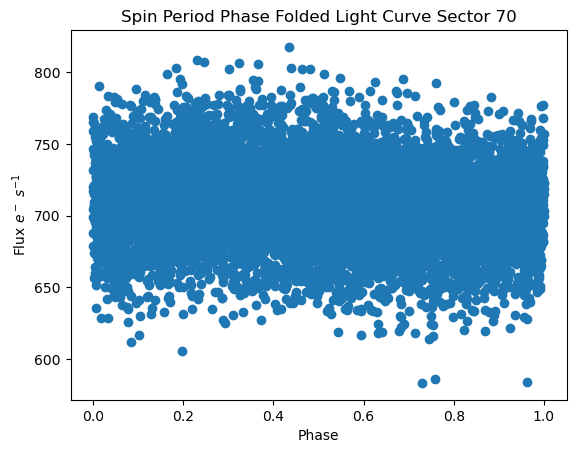

In [43]:
t4 = time4[0]

# Compute cycle number
n4 = (time4 - t4) / pspin4

# Compute new x-axis (integer cycles + phase)
spin_folded4 = (n4 % 1)

# Sort for smoother plotting
sorted_indices = np.argsort(spin_folded4)
spin_folded_sorted4 = spin_folded4[sorted_indices]
spin_flux_sorted4 = flux4[sorted_indices]

plt.scatter(spin_folded_sorted4, spin_flux_sorted4)
plt.title('Spin Period Phase Folded Light Curve Sector 70')
plt.xlabel('Phase')
plt.ylabel('Flux $e^-$ $s^{-1}$')

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.557e+00  1.033e+00 ... -1.166e+00  3.971e+00]
           x: [ 2.511e+01  6.684e+00  2.794e-01 -1.940e+00  7.080e+02]
        cost: 131779.74236810242
         jac: [[ 2.027e-01  1.041e+04 ...  4.115e-02  2.027e-01]
               [ 2.025e-01  1.720e+03 ...  2.042e-03  2.032e-01]
               ...
               [ 4.388e-02  6.744e+04 ...  5.613e-02  1.711e-01]
               [ 5.982e-02  6.591e+04 ...  8.643e-02  1.713e-01]]
        grad: [ 9.159e+02  8.711e+08  3.014e+05 -7.781e+02 -1.418e+01]
  optimality: 871081065.876604
 active_mask: [0 0 0 0 0]
        nfev: 23
        njev: None
   param_cov: [[ 5.701e-03  2.045e-09 ...  2.396e-05  2.617e-05]
               [ 2.045e-09  3.485e-11 ... -1.526e-10 -3.362e-10]
               ...
               [ 2.396e-05 -1.526e-10 ...  5.705e-03  7.741e-06]
               [ 2.617e-05 -3.362e-10 ...  7.741e-06  2.851e-03]]
32.5301758499388

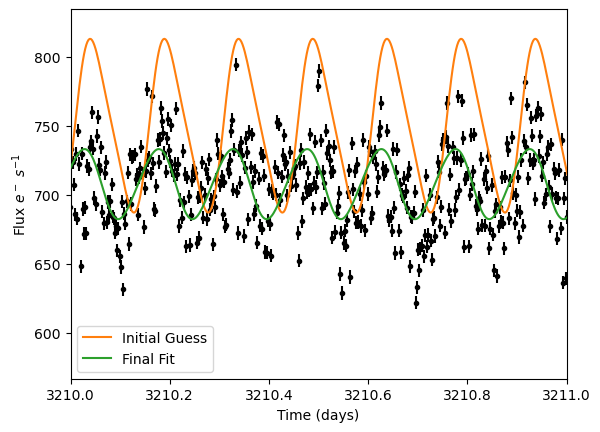

In [44]:
sine41 = models.Sine1D(amplitude=60, frequency=6.684327157529621, phase=0.25)
sine42 = models.Sine1D(amplitude=10, frequency=2*6.684327157529621, phase=0.5)
constant4 = models.Const1D(amplitude=750)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_orb4 = sine41 + sine42 + constant4

def tie_freq(model):
    return model.frequency_0 * 2

sine42.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine42.phase.tied = tie_phase

sin_final_orb4 = fit_sin(sin_init_orb4, time4, flux4, weights=1/flux_error4, maxiter=10000,acc=1e-10)

print(fit_sin.fit_info)

chi2_orb4 = np.sum(((sin_final_orb4(time4)-flux4)/flux_error4)**2)
chi2_r_orb4 = chi2_orb4/(len(time4)-3)
print(chi2_r_orb4)

pfit_orb4 = fit_sin.fit_info.x
pcov_orb4 = fit_sin.fit_info.param_cov * chi2_r_orb4
print(pcov_orb4)
error_orb4 = []

for i in range(len(pfit_orb4)):
    error_orb4.append(np.absolute(pcov_orb4[i][i])**0.5)
        
perr_leastsq_orb4 = np.array(error_orb4) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_orb4)
print("perr = \ ", perr_leastsq_orb4)

plt.errorbar(time4, flux4, flux_error4, fmt='k.', zorder=1),
plt.plot(time4, sin_init_orb4(time4),'C1', label='Initial Guess', zorder=2)
plt.plot(time4, sin_final_orb4(time4),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.xlim(3210,3211)
plt.legend()
plt.show()

In [45]:
residual4 = flux4-sin_final_orb4(time4)

Text(0.5, 1.0, 'Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 70')

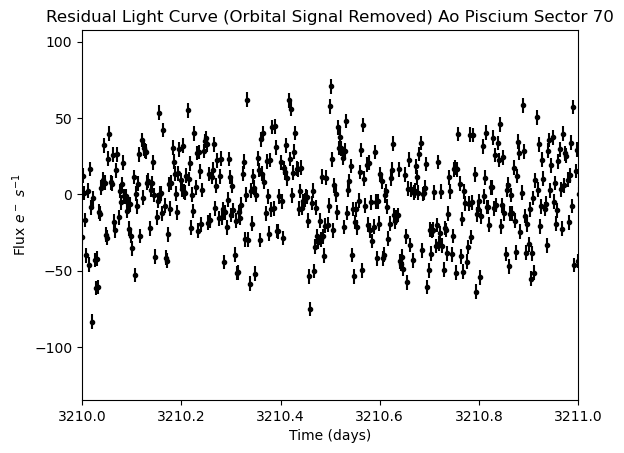

In [46]:
plt.errorbar(time4, residual4, yerr=flux_error4, fmt='k.')
plt.xlim(3210,3211)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.title('Residual Light Curve (Orbital Signal Removed) Ao Piscium Sector 70')

(0.0, 100.0)

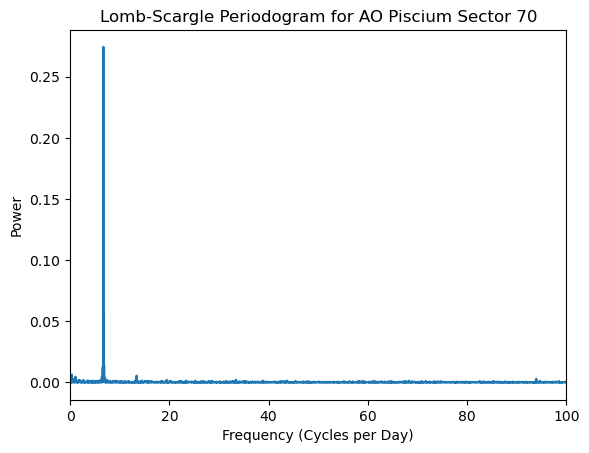

In [47]:
#Define frequency range
min_freq = 0.1  # Lower bound of frequencies
max_freq = 1 / (2 * np.median(np.diff(time4)))  # Nyquist frequency

frequencies43 = np.linspace(min_freq, max_freq, 1000000) 

power43 = LombScargle(time4, flux4).power(frequencies43)

plt.plot(frequencies43, power43)
plt.title('Lomb-Scargle Periodogram for AO Piscium Sector 70')
plt.ylabel('Power')
plt.xlabel('Frequency (Cycles per Day)')
plt.xlim(0,100)

     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 2.063e+00  2.425e+00 ... -6.082e-01  2.870e+00]
           x: [-7.557e+00  1.006e+02 -2.380e-01]
        cost: 126772.24372228998
         jac: [[ 6.541e-02  2.923e+04  9.108e+00]
               [-1.842e-01  1.307e+04  4.074e+00]
               ...
               [-7.387e-02 -2.369e+04 -7.327e+00]
               [ 1.457e-01 -1.383e+04 -4.278e+00]]
        grad: [ 3.278e-06 -2.794e+02 -8.712e-02]
  optimality: 279.384749871213
 active_mask: [0 0 0]
        nfev: 8
        njev: 7
   param_cov: [[ 5.702e-03  2.333e-09 -7.489e-06]
               [ 2.333e-09  4.408e-08 -1.420e-04]
               [-7.489e-06 -1.420e-04  4.574e-01]]
31.294061644603797
[[ 1.78423876e-01  7.30082771e-08 -2.34372881e-04]
 [ 7.30082771e-08  1.37929327e-06 -4.44319277e-03]
 [-2.34372881e-04 -4.44319277e-03  1.43131788e+01]]
Fit parameters and parameter errors from lestsq method :\ 
pfit = \  [ -7.55650405 1

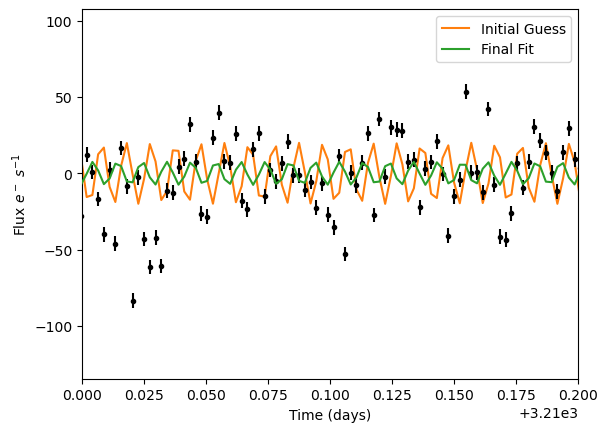

In [48]:
sine41 = models.Sine1D(amplitude=20, frequency=100.62693387353555, phase=0)
sine42 = models.Sine1D(amplitude=1, frequency=100.62693387353555-6.684327157529621, phase=0.25)

fit_sin = fitting.LMLSQFitter(calc_uncertainties=True)

sin_init_spin4 = sine41 #+ sine42

def tie_freq(model):
    return model.frequency_0 - 6.684327157529621

sine42.frequency.tied = tie_freq

def tie_phase(model):
    return model.phase_0 + 0.25

sine42.phase.tied = tie_phase

sin_final_spin4 = fit_sin(sin_init_spin4, time4, residual4, weights=1/flux_error4, maxiter=1000,acc=1e-10)

print(fit_sin.fit_info)

chi2_spin4 = np.sum(((sin_final_spin4(time4)-residual4)/flux_error4)**2)
chi2_r_spin4 = chi2_spin4/(len(time4)-3)
print(chi2_r_spin4)

pfit_spin4 = fit_sin.fit_info.x
pcov_spin4 = fit_sin.fit_info.param_cov * chi2_r_spin4
print(pcov_spin4)
error_spin4 = []

for i in range(len(pfit_spin4)):
    error_spin4.append(np.absolute(pcov_spin4[i][i])**0.5)
        
perr_leastsq_spin4 = np.array(error_spin4) 
        
print("Fit parameters and parameter errors from lestsq method :\ ")
print("pfit = \ ", pfit_spin4)
print("perr = \ ", perr_leastsq_spin4)

plt.errorbar(time4, residual4, flux_error4, fmt='k.', zorder=2),
plt.plot(time4, sin_init_spin4(time4),'C1', label='Initial Guess', zorder=1)
plt.plot(time4, sin_final_spin4(time4),'C2', label='Final Fit', zorder=3)
plt.xlabel('Time (days)')
plt.ylabel('Flux $e^-$ $s^{-1}$')
plt.legend()
plt.xlim(3210, 3210.2)
plt.show()

In [49]:
pspin4_model = 1/pfit_spin4[1]
pspin4_models = pspin4_model*u.day.to(u.s)

pspin4_model_error = (1/pfit_spin4[1])*(perr_leastsq_spin4[1])
pspin4_model_errors = pspin4_model_error*u.day.to(u.s)

print(pspin4_models)
print(pspin4_model_errors)

858.6167978943771
1.0083880479344451


## Data Yurt

In [50]:
data.loc["Orbital Frequency (days⁻¹)", :] = [forb0, forb1, forb2, np.nan, forb4]
data.loc["Orbital Period (hours)", :] = [porb0h, porb1h, porb2h, np.nan, porb4h]
data.loc["Spin Frequency (days⁻¹)", :] = [fspin0, fspin1, fspin2, np.nan, fspin4]
data.loc["Spin Period (seconds)", :] = [pspin0s, pspin1s, pspin2s, np.nan, pspin4s]
data.loc["Model Spin Period (seconds)", :] = [pspin0_models, pspin1_models, pspin2_models, np.nan, pspin4_models]
data.loc["Model Spin Period Error (seconds)", :] = [pspin0_model_errors, pspin1_model_errors, pspin2_model_errors, np.nan, pspin4_model_errors]
data.loc["Model Spin Period Reduced χ2", :] = [chi2_r_spin0, chi2_r_spin1, chi2_r_spin2, np.nan, chi2_r_spin4]
print(data)

                                   0: Sector42  1: Sector42  2: Sector70  \
Orbital Frequency (days⁻¹)            6.683398     6.682598     6.683967   
Orbital Period (hours)                3.590988     3.591417     3.590682   
Spin Frequency (days⁻¹)             100.628911   100.628183   100.627894   
Spin Period (seconds)               858.600166   858.606385   858.608845   
Model Spin Period (seconds)         858.607774   858.608087   858.651653   
Model Spin Period Error (seconds)     0.253977     0.785895     2.863985   
Model Spin Period Reduced χ2          6.117688    19.013905    27.019127   

                                   3: Sector42  4: Sector70  
Orbital Frequency (days⁻¹)                 NaN     6.684327  
Orbital Period (hours)                     NaN     3.590489  
Spin Frequency (days⁻¹)                    NaN   100.626934  
Spin Period (seconds)                      NaN   858.617039  
Model Spin Period (seconds)                NaN   858.616798  
Model Spin Period E

In [51]:
data.to_csv("AO_Piscium_Spin_Periods.csv")